In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score , recall_score , precision_score

In [2]:
df = pd.read_csv(
    "2019-Nov.csv",
    nrows = 100_000

)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     100000 non-null  object 
 1   event_type     100000 non-null  object 
 2   product_id     100000 non-null  int64  
 3   category_id    100000 non-null  int64  
 4   category_code  66160 non-null   object 
 5   brand          84224 non-null   object 
 6   price          100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_session   100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [5]:
# Converting event_time to Datetime
df['event_time'] = pd.to_datetime(df['event_time'])

In [6]:
# Time based data requires sorted data , so we will sort it: 
# So we sort values by user_id and event_time

df = df.sort_values(by=['user_id' , 'event_time'])

In [7]:
# We need the count of views per session , and store it in a new variable called pages_viewed

pages_viewed = (
    df[df['event_type'] == 'view']
    .groupby(['user_id' , 'user_session'])
    .size()
    .rename('pages_viewed')
)

In [8]:
# Count of carts per session
cart_additions = (
    df[df['event_type'] == 'cart']
    .groupby(['user_id' , 'user_session'])
    .size()
    .rename('cart_additions')
)

In [9]:
# Purchase Status -> If any purchase happened in session then 1 else 0

purchase_status = (
    df[df['event_type'] == 'purchase']
    .groupby(['user_id', 'user_session'])
    .size()
    .rename('purchase_status')
)
purchase_status = purchase_status.apply(lambda x: 1)

In [10]:
# Session Duration

session_duration = (
    df.groupby(['user_id', 'user_session'])['event_time']
    .agg(lambda x: (x.max() - x.min()).total_seconds())
    .rename('session_duration')
)

In [11]:
# Now combining all session features :-

session_features = pd.concat(
    [pages_viewed, cart_additions, session_duration, purchase_status],
    axis=1
).fillna(0)

In [12]:
# Here , missing values is replaced by 0.
# Sessions without cart / purchase are handled correctly.

In [13]:
# Past Purchase Count:-

# Now we calculate the total purchases made my the user before modeling.

past_purchase_count = (
    df[df['event_type'] == 'purchase']
    .groupby('user_id')
    .size()
    .rename('past_purchase_count')
)

In [14]:
# Now past_purchase_count with session_features:-

final_df = session_features.reset_index().merge(
    past_purchase_count,
    on='user_id',
    how='left'
)
final_df['past_purchase_count'] = final_df['past_purchase_count'].fillna(0)

In [15]:
final_df.head()


,user_id,user_session,pages_viewed,cart_additions,session_duration,purchase_status,past_purchase_count
0,275256741,48b5b9c0-3d1b-4380-94f8-dcadb9dd7b5c,1.0,0.0,0.0,0.0,0.0
1,295643776,775c16bc-4ba0-48dd-a13e-e387b6e482e6,1.0,0.0,0.0,0.0,0.0
2,295643776,792efec7-50ac-461d-af96-061d1e1d12cf,7.0,0.0,178.0,0.0,0.0
3,356520186,3e3403b6-2a19-4a1d-aef2-ee4dce0dc943,5.0,0.0,595.0,1.0,1.0
4,389979783,55e573a5-c8b1-4896-9df7-2c33e32223d1,4.0,0.0,51.0,0.0,0.0


In [16]:
# Now adding addtional features to make the model learn better:-
# Binary Cart intent flag

final_df['has_cart'] = (final_df['cart_additions'] > 0).astype(int)

In [17]:
# engagement_score

final_df['engagement_score'] = (
    final_df['pages_viewed'] * final_df['session_duration']
)

# Here low score is a bounced user , and high score indicates deeply engaged user.

In [18]:
# is_returning_user:-

''' Business usage in this is that new users - high awareness campaigns , while returning users
 - conversion campaigns '''

final_df['is_returning_user'] = (
    final_df['past_purchase_count'] > 0
).astype(int)

In [19]:
# Saving the feature engineered dataset 

final_df.to_csv("engineered_ecommerce_sessions1.csv", index=False)

In [20]:
final_df.head()

,user_id,user_session,pages_viewed,cart_additions,session_duration,purchase_status,past_purchase_count,has_cart,engagement_score,is_returning_user
0,275256741,48b5b9c0-3d1b-4380-94f8-dcadb9dd7b5c,1.0,0.0,0.0,0.0,0.0,0,0.0,0
1,295643776,775c16bc-4ba0-48dd-a13e-e387b6e482e6,1.0,0.0,0.0,0.0,0.0,0,0.0,0
2,295643776,792efec7-50ac-461d-af96-061d1e1d12cf,7.0,0.0,178.0,0.0,0.0,0,1246.0,0
3,356520186,3e3403b6-2a19-4a1d-aef2-ee4dce0dc943,5.0,0.0,595.0,1.0,1.0,0,2975.0,1
4,389979783,55e573a5-c8b1-4896-9df7-2c33e32223d1,4.0,0.0,51.0,0.0,0.0,0,204.0,0


Exploratory Data Analysis

In [21]:
# Q1. Which user behavior indicate high purchase intent?

In [22]:
# pages_viewed Vs purchase_status
final_df.groupby('purchase_status')['pages_viewed'].mean()

purchase_status
0.0    3.863346
1.0    4.929089
Name: pages_viewed, dtype: float64

In [23]:
# cart_additions Vs purchase_status
final_df.groupby('purchase_status')['cart_additions'].mean()

purchase_status
0.0    0.022494
1.0    0.448832
Name: cart_additions, dtype: float64

In [24]:
# engagement_Score Vs purchase_status
final_df.groupby('purchase_status')['engagement_score'].mean()

purchase_status
0.0    2346.921906
1.0    3871.997583
Name: engagement_score, dtype: float64

In [25]:
# Returning Vs New Users
final_df.groupby('is_returning_user')['purchase_status'].mean()

is_returning_user
0    0.000000
1    0.758094
Name: purchase_status, dtype: float64

In [26]:
# Q2. Do cart additions increase conversion? 

In [27]:
# Conversion rate with cart

conversion_with_cart = (
    final_df[final_df['has_cart'] == 1]['purchase_status'].mean()
)

In [28]:
# Conversion rate without cart
conversion_without_cart = (
    final_df[final_df['has_cart'] == 0]['purchase_status'].mean()
)

In [29]:
print(conversion_with_cart, conversion_without_cart)

0.5095367847411444 0.035888732510969454


In [30]:
# Q3. What distinguishes buyers vs non-buyers?

In [31]:
final_df.groupby('purchase_status')[
    ['session_duration', 'engagement_score', 'past_purchase_count']
].mean()

,session_duration,engagement_score,past_purchase_count
purchase_status,,,
0.0,199.207391,2346.921906,0.023466
1.0,396.991942,3871.997583,1.377115


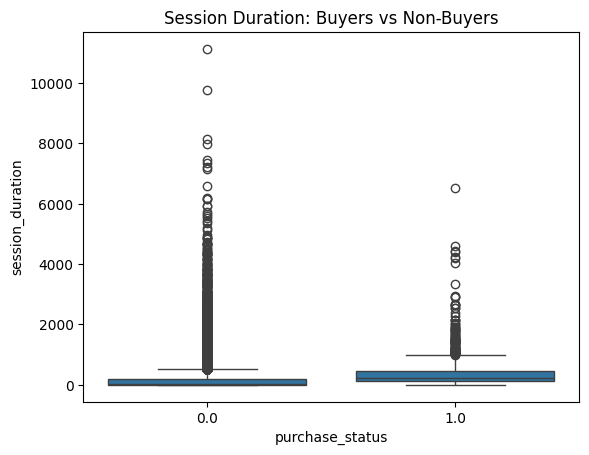

In [32]:
sns.boxplot(x='purchase_status', y='session_duration', data=final_df)
plt.title("Session Duration: Buyers vs Non-Buyers")
plt.show()

In [33]:
''' Before model building , there are some criterias 
    we need to check , so that the model don't predict wrong and 
    give good accuracy for that , like for example :-
    In purchase_status column mostly values are 0's , and very rare 1's 
    so , the model may consider that no customers purchase from the shop 
    , this means the model predicted incorrectly. '''

# 1. Class Imbalance:-
#  If even one class is less than 10-15% , then it's imbalanced.

final_df['purchase_status'].value_counts(normalize=True)

purchase_status
0.0    0.950145
1.0    0.049855
Name: proportion, dtype: float64

In [34]:
''' From the above output , we can find that , customers whose purchase_status is 0 , their 
    class is 95% , while whose purchase_status is 1 , their class is 4% , which is highly 
    imbalanced. '''

model = LogisticRegression(class_weight='balanced')

In [35]:
''' 2. Feature skewness:-
    If skew > +1 , then it's heavily right skewed. '''

final_df[['session_duration', 'engagement_score']].describe()


,session_duration,engagement_score
count,24892.000000,24892.000000
mean,209.068014,2422.955126
std,472.513452,11370.614008
min,0.000000,0.000000
25%,0.000000,0.000000
50%,50.000000,112.000000
75%,219.000000,955.000000
max,11130.000000,470935.000000


In [36]:
final_df[['session_duration', 'engagement_score']].skew()

session_duration     6.263208
engagement_score    15.313100
dtype: float64

In [37]:
''' We need to handle the above case -
    log1p handles zero safely , and improves linear model learning.'''
final_df['log_session_duration'] = np.log1p(final_df['session_duration'])
final_df['log_engagement_score'] = np.log1p(final_df['engagement_score'])

In [38]:
'''
   3. Feature scale mismatch:-
   This criteria is used if feature ranges differ greatly.
'''

final_df[['pages_viewed', 'session_duration', 'engagement_score']].describe()

,pages_viewed,session_duration,engagement_score
count,24892.000000,24892.000000,24892.000000
mean,3.916479,209.068014,2422.955126
std,5.409373,472.513452,11370.614008
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,50.000000,112.000000
75%,4.000000,219.000000,955.000000
max,140.000000,11130.000000,470935.000000


In [39]:
'''scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)'''

# We used this because unscaled features dominate learning , so we need to scale those features first.
# To be implemented later. Because no features are defined yet like the variable X.

'scaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)'

In [40]:
'''
   4. Correlated / Redundant Features:-
   If correlation coefficient > 0.8 or < (-0.8) , this is the way to identify correlation.
'''

final_df[['cart_additions', 'has_cart']].corr()

,cart_additions,has_cart
cart_additions,1.00000,0.77431
has_cart,0.77431,1.00000


In [41]:
''' 
5. Data Leakage:-
Here we check if any feature depend on target variable.
'''

final_df.columns

Index(['user_id', 'user_session', 'pages_viewed', 'cart_additions',
       'session_duration', 'purchase_status', 'past_purchase_count',
       'has_cart', 'engagement_score', 'is_returning_user',
       'log_session_duration', 'log_engagement_score'],
      dtype='object')

In [42]:
'''
6. Check for data bias:-
Bias in our project case means , if new users are more than returning users , then 
it means the data is biased. No need to do anything with the bias , it's a natural business
bias , and not a data error.
'''

"\n6. Check for data bias:-\nBias in our project case means , if new users are more than returning users , then \nit means the data is biased. No need to do anything with the bias , it's a natural business\nbias , and not a data error.\n"

In [43]:
'''
 7. Overfitting handling:-
 After training , if Training score >> Test score , then this is the overfitting case.
'''

'\n 7. Overfitting handling:-\n After training , if Training score >> Test score , then this is the overfitting case.\n'

In [44]:
##########################################################################

In [45]:
# Defining here the features and the target variable:-
features = [
    'pages_viewed',
    'cart_additions',
    'has_cart',
    'session_duration',
    'engagement_score',
    'past_purchase_count',
    'is_returning_user'
]
X = final_df[features]
y = final_df['purchase_status']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [48]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000
    ))
])
lr_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [50]:
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
roc_auc_score(y_test, y_proba_lr)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      4731
         1.0       0.75      1.00      0.86       248

    accuracy                           0.98      4979
   macro avg       0.87      0.99      0.92      4979
weighted avg       0.99      0.98      0.98      4979



0.9961437430537089

In [52]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [53]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
roc_auc_score(y_test, y_proba_rf)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      4731
         1.0       0.86      0.93      0.89       248

    accuracy                           0.99      4979
   macro avg       0.93      0.96      0.94      4979
weighted avg       0.99      0.99      0.99      4979



0.9966129373180327

In [55]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight = (
        (y_train == 0).sum() / (y_train == 1).sum()
    ),
    random_state=42
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [56]:
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
roc_auc_score(y_test, y_proba_xgb)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      4731
         1.0       0.83      0.99      0.90       248

    accuracy                           0.99      4979
   macro avg       0.92      0.99      0.95      4979
weighted avg       0.99      0.99      0.99      4979



0.996863941334097

In [57]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

In [59]:
feature_importance

,feature,importance
5,past_purchase_count,0.471590
6,is_returning_user,0.362055
3,session_duration,0.068976
4,engagement_score,0.053396
2,has_cart,0.017077
1,cart_additions,0.016760
0,pages_viewed,0.010146


<Axes: ylabel='feature'>

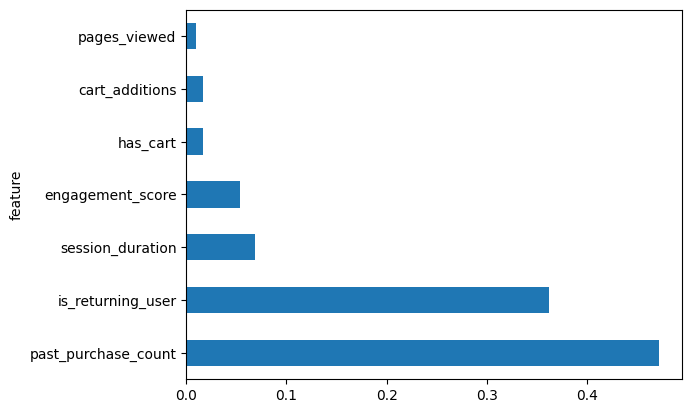

In [61]:
feature_importance.plot(kind='barh', x='feature', y='importance', legend=False)

In [58]:
final_df['purchase_probability'] = rf_model.predict_proba(X)[:, 1]

In [ ]:
final_df[['user_id', 'purchase_probability']].head()

,user_id,purchase_probability
0,275256741,0.000
1,295643776,0.000
2,295643776,0.000
3,356520186,0.975
4,389979783,0.000


In [67]:
final_df[['user_id', 'purchase_probability']].tail()

,user_id,purchase_probability
24887,533326659,0.015
24888,548803548,0.650
24889,565852473,0.015
24890,566290277,0.015
24891,538440830,0.655


In [68]:
final_df[['user_id', 'purchase_probability']].tail(30)

,user_id,purchase_probability
24862,566309713,0.000
24863,566309730,0.000
24864,566309735,0.000
24865,566309736,0.000
24866,566309745,0.000
24867,566309750,0.000
24868,566309763,0.000
24869,566309765,0.000
24870,566309780,0.000
24871,566309784,0.000


In [69]:
def segment_user(p):
    if p >= 0.7:
        return 'High Intent'
    elif p >= 0.4:
        return 'Medium Intent'
    else:
        return 'Low Intent'

final_df['intent_segment'] = final_df['purchase_probability'].apply(segment_user)

In [70]:
final_df['intent_segment'].value_counts()

intent_segment
Low Intent       23589
High Intent       1230
Medium Intent       73
Name: count, dtype: int64

In [72]:
results = []

def evaluate_model(name, y_test, y_pred, y_proba):
    results.append({
        'Model': name,
        'Recall (Buyers)': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

In [73]:
evaluate_model(
    'Logistic Regression',
    y_test,
    y_pred_lr,
    y_proba_lr
)

In [74]:
evaluate_model(
    'Random Forest',
    y_test,
    y_pred_rf,
    y_proba_rf
)

In [75]:
evaluate_model(
    'XGBoost',
    y_test,
    y_pred_xgb,
    y_proba_xgb
)

In [76]:
results_df = pd.DataFrame(results)
results_df

,Model,Recall (Buyers),ROC-AUC
0,Logistic Regression,1.000000,0.996144
1,Random Forest,0.931452,0.996613
2,XGBoost,0.987903,0.996864


In [78]:
def get_metrics(y_true, y_pred, y_proba):
    return {
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'ROC_AUC': roc_auc_score(y_true, y_proba)
    }


In [79]:
metrics = []

metrics.append({
    'Model': 'Logistic Regression',
    **get_metrics(y_test, y_pred_lr, y_proba_lr)
})

metrics.append({
    'Model': 'Random Forest',
    **get_metrics(y_test, y_pred_rf, y_proba_rf)
})

metrics.append({
    'Model': 'XGBoost',
    **get_metrics(y_test, y_pred_xgb, y_proba_xgb)
})

In [80]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Recall,Precision,ROC_AUC
0,Logistic Regression,1.000000,0.746988,0.996144
1,Random Forest,0.931452,0.855556,0.996613
2,XGBoost,0.987903,0.833333,0.996864


In [81]:
qualitative = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Handles_Imbalance': [2, 3, 3],
    'Interpretability': [3, 2, 2],
    'Deployment_Ready': [3, 3, 3]
})

In [82]:
scorecard = metrics_df.merge(qualitative, on='Model')
scorecard

,Model,Recall,Precision,ROC_AUC,Handles_Imbalance,Interpretability,Deployment_Ready
0,Logistic Regression,1.000000,0.746988,0.996144,2,3,3
1,Random Forest,0.931452,0.855556,0.996613,3,2,3
2,XGBoost,0.987903,0.833333,0.996864,3,2,3


In [83]:
weights = {
    'Recall': 0.35,
    'ROC_AUC': 0.30,
    'Precision': 0.15,
    'Handles_Imbalance': 0.10,
    'Interpretability': 0.05,
    'Deployment_Ready': 0.05
}


scorecard['Final_Score'] = (
    scorecard['Recall'] * weights['Recall'] +
    scorecard['ROC_AUC'] * weights['ROC_AUC'] +
    scorecard['Precision'] * weights['Precision'] +
    scorecard['Handles_Imbalance'] * weights['Handles_Imbalance'] +
    scorecard['Interpretability'] * weights['Interpretability'] +
    scorecard['Deployment_Ready'] * weights['Deployment_Ready']
)

scorecard.sort_values(by='Final_Score', ascending=False)

,Model,Recall,Precision,ROC_AUC,Handles_Imbalance,Interpretability,Deployment_Ready,Final_Score
2,XGBoost,0.987903,0.833333,0.996864,3,2,3,1.319825
1,Random Forest,0.931452,0.855556,0.996613,3,2,3,1.303325
0,Logistic Regression,1.000000,0.746988,0.996144,2,3,3,1.260891


In [84]:
final_features = [
    'pages_viewed',
    'cart_additions',
    'has_cart',
    'session_duration',
    'engagement_score',
    'past_purchase_count',
    'is_returning_user'
]

In [86]:
final_model = xgb_model

In [87]:
final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [88]:
final_model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [85]:
HIGH_INTENT_THRESHOLD = 0.7
MEDIUM_INTENT_THRESHOLD = 0.4

In [89]:
from sklearn.metrics import classification_report, roc_auc_score

y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= HIGH_INTENT_THRESHOLD).astype(int)

print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_proba)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      4731
         1.0       0.86      1.00      0.93       248

    accuracy                           0.99      4979
   macro avg       0.93      1.00      0.96      4979
weighted avg       0.99      0.99      0.99      4979



0.9992239756990611

In [90]:
import pickle

with open("purchase_intent_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [91]:
model_metadata = {
    'model_name': 'XGBoost',
    'features': final_features,
    'thresholds': {
        'high_intent': 0.7,
        'medium_intent': 0.4
    },
    'evaluation_metric': 'ROC-AUC',
    'roc_auc_score': 0.996864,
    'business_goal': 'Target high-intent users to optimize marketing spend'
}

with open("model_metadata.pkl", "wb") as f:
    pickle.dump(model_metadata, f)